In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import Model, Input, losses, metrics
from tensorflow.keras.layers import Conv2D, BatchNormalization, Add, Dense, Concatenate
from tensorflow.keras.layers import Activation, MaxPooling2D, Flatten, GlobalAveragePooling2D

## **GPU Utilization**

Deep neural networks process vast amounts of data and perform billions of computations, making training time a critical factor. GPUs (Graphics Processing Units) are designed to handle massive parallel computations, significantly accelerating model training compared to CPUs.

GPU Utilization is important because of:

*   faster training
*   efficient resource usage
*   scalability
*   cost-effectiveness

In [2]:
# checking to see if GPU is detected
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# setting tensorflow to use GPU (if available)
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"Using GPU: {device_name}")
else:
    print("No GPU found. Training will proceed on CPU.")

Num GPUs Available: 1
Using GPU: /device:GPU:0


In [3]:
from tensorflow.keras import mixed_precision

# mixed precision for better performance
mixed_precision.set_global_policy("mixed_float16")

# allocating GPU memory dynamically
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)

GPU memory growth enabled


## **CIFAR-10 Dataset**

The CIFAR-10 (Canadian Institute For Advanced Research) dataset is one of the most widely used benchmarks in image classification. It consists of:

**60,000 Color Images** – Each image is 32x32 pixels with RGB channels.

**10 Balanced Classes** – 6,000 images per class, covering a diverse range of objects:

*   ✈️ Airplane
*   🚗 Automobile
*   🐦 Bird
*   🐈 Cat
*   🦌 Deer
*   🐕 Dog
*   🐸 Frog
*   🐎 Horse
*   🚢 Ship
*   🚚 Truck

CIFAR-10 is a small yet challenging dataset for testing new architectures. There is no class imbalance, so we can be sure that the models are being trained fairly. This data is suitable for experiments even on limited hardware and is widely used as one of the famous benchmarks for evaluating DL model performance.

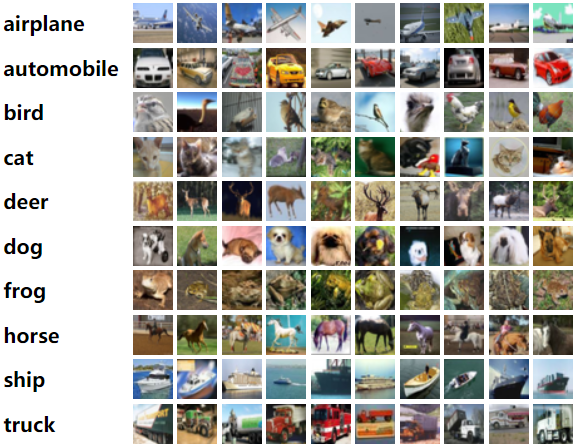

In [36]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalizing the data to [0, 1] range
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encoding the labels for classification tasks
y_train_class = tf.keras.utils.to_categorical(y_train, 10)
y_test_class = tf.keras.utils.to_categorical(y_test, 10)

## **ResNet**

A residual neural network (also referred to as a residual network or ResNet) is a deep learning architecture in which the layers learn residual functions with reference to the layer inputs. It was developed in 2015 for image recognition, and won the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) of that year.

As a point of terminology, "residual connection" refers to the specific architectural motif of x ↦ f(x) + x, where f is an arbitrary neural network module. The motif had been used previously. However, the publication of ResNet made it widely popular for feedforward networks, appearing in neural networks that are seemingly unrelated to ResNet.

The residual connection stabilizes the training and convergence of deep neural networks with hundreds of layers, and is a common motif in deep neural networks, such as transformer models (BERT, GPT), the AlphaGo Zero system, the AlphaStar system, and the AlphaFold system.

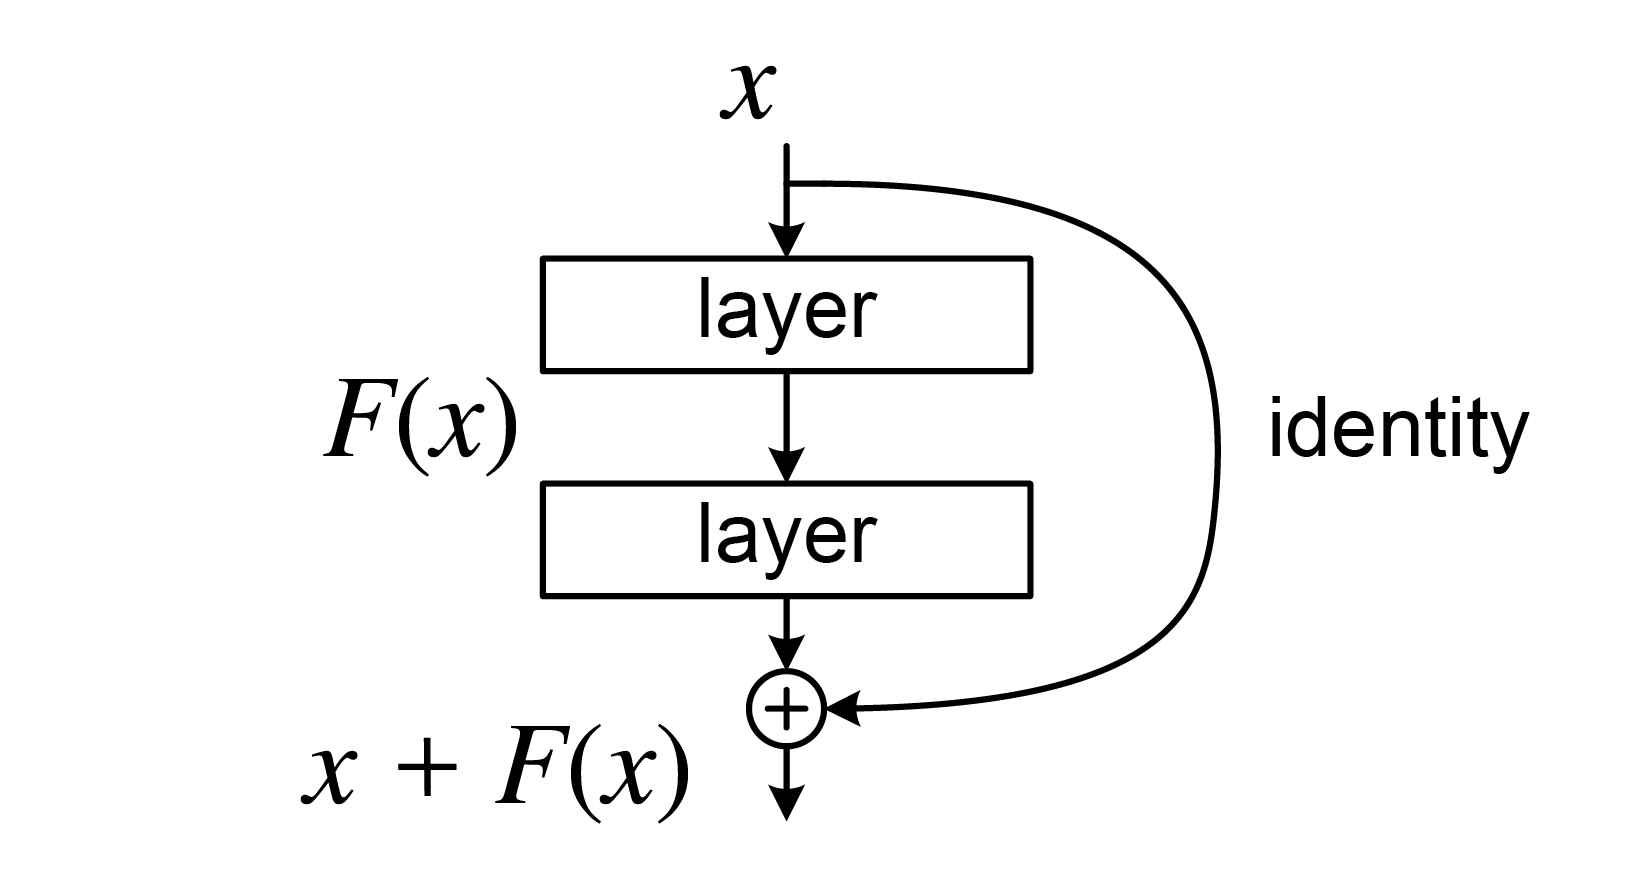

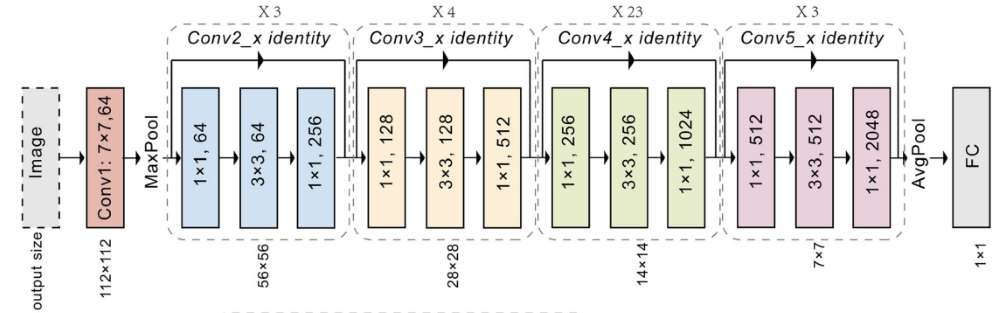

The benefit of including this kind of skip link is that regularisation will skip any layer that degrades architecture performance. As a result, training an extremely deep neural network is possible without encountering issues with vanishing or expanding gradients. The CIFAR-10 dataset’s 100–1000 layers were used for experimentation by the paper’s authors.

Similar techniques exist under the name “highway networks,” which also employ skip connections. These skip connections also make use of parametric gates, just as LSTM. The amount of data that flows across the skip connection is controlled by these gates. However, this design has not been proved to deliver superior accuracy than ResNet.

In [37]:
def residual_block(x, filters, kernel_size=3, stride=1, use_projection=False):
    shortcut = x

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if use_projection:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

In [38]:
def create_resnet(input_shape, num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, use_projection=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, use_projection=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, use_projection=True)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [39]:
# defining the input shape for CIFAR-10 (32x32 RGB images)
input_shape = (32, 32, 3)

In [40]:
with tf.device('/GPU:0'):
    model_resnet = create_resnet(input_shape, num_classes=10)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history_resnet = model_resnet.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 68s 48ms/step - accuracy: 0.4316 - loss: 1.7459 - val_accuracy: 0.4963 - val_loss: 1.5553
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.7125 - loss: 0.8100 - val_accuracy: 0.7182 - val_loss: 0.8169
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.7993 - loss: 0.5802 - val_accuracy: 0.7245 - val_loss: 0.9128
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 26ms/step - accuracy: 0.8472 - loss: 0.4383 - val_accuracy: 0.7784 - val_loss: 0.6550
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.8849 - loss: 0.3320 - val_accuracy: 0.7723 - val_loss: 0.7583
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9188 - loss: 0.2306 - val_accuracy: 0.8252 - val_loss: 0.5682
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9433 - loss: 0.1629 - val_accuracy: 0.7895 - val_loss: 0.7964
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.9571 - loss: 0.1224 - 

In [41]:
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(x_test, y_test_class)
print(f"Test Accuracy for Classification Task: {test_acc_resnet * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7635 - loss: 1.2398
Test Accuracy for Classification Task: 75.99%


In [42]:
def plot_sample_classification_predictions(model, x_test, y_test):
    """Displays some test images with actual and predicted labels for classification."""
    class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']  # CIFAR-10 Labels

    fig, axes = plt.subplots(3, 5, figsize=(12, 8))
    indices = np.random.choice(len(x_test), 15, replace=False)

    for i, ax in enumerate(axes.flat):
        img = x_test[indices[i]]
        true_label = np.argmax(y_test[indices[i]])
        pred_label = np.argmax(model.predict(img.reshape(1, 32, 32, 3)))

        ax.imshow(img)
        ax.set_title(f"Actual: {class_labels[true_label]}\nPred: {class_labels[pred_label]}",
                     color=("green" if true_label == pred_label else "red"))
        ax.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


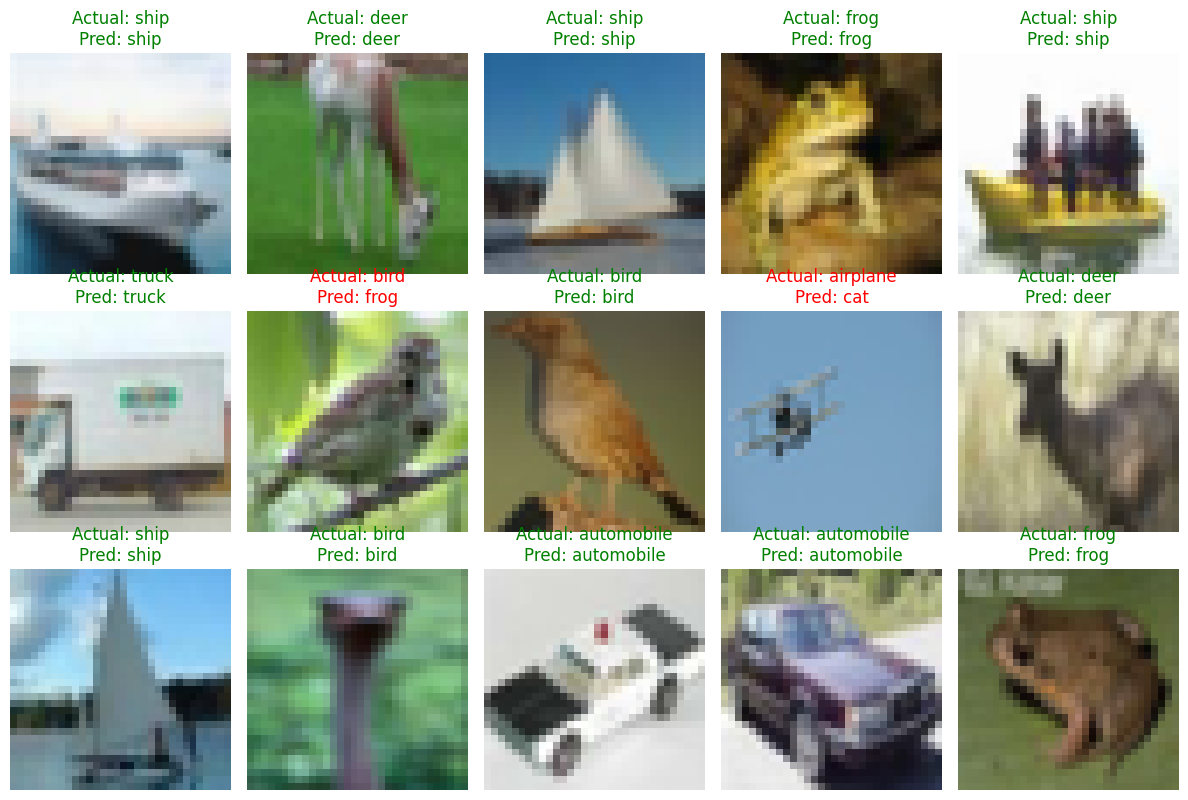

In [43]:
plot_sample_classification_predictions(model_resnet, x_test, y_test_class)

In [44]:
# **************************************
# TASK 1 - WORKING WITH GRAYSCALE IMAGES
# **************************************

# Modify a ResNet model to work with grayscale images (1 channel
# instead of 3) and retrain it on a dataset like MNIST or Fashion-MNIST.

# WRITE YOUR CODE HERE
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

# Create ResNet Model
def modified_resnet(input_shape, num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2, use_projection=True)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2, use_projection=True)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2, use_projection=True)
    x = residual_block(x, 512)

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# normalizing the data to [0, 1] range
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encoding the labels for classification tasks
y_train_class = tf.keras.utils.to_categorical(y_train, 10)
y_test_class = tf.keras.utils.to_categorical(y_test, 10)

with tf.device('/GPU:0'):
    model_resnet = modified_resnet(input_shape=(28, 28, 1), num_classes=10)
    model_resnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history_resnet = model_resnet.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))


# **************************************

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 43ms/step - accuracy: 0.7849 - loss: 0.6444 - val_accuracy: 0.8582 - val_loss: 0.4049
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 47s 22ms/step - accuracy: 0.9095 - loss: 0.2491 - val_accuracy: 0.9129 - val_loss: 0.2588
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9259 - loss: 0.2031 - val_accuracy: 0.9078 - val_loss: 0.2762
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9367 - loss: 0.1731 - val_accuracy: 0.8972 - val_loss: 0.3381
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9446 - loss: 0.1460 - val_accuracy: 0.9167 - val_loss: 0.2484
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - accuracy: 0.9595 - loss: 0.1141 - val_accuracy: 0.9042 - val_loss: 0.2966
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9658 - loss: 0.0974 - val_accuracy: 0.9247 - val_loss: 0.2413
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 22ms/step - accuracy: 0.9749 - loss: 0.0705 - 

In [45]:
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(x_test, y_test_class)
print(f"Test Accuracy for Classification Task: {test_acc_resnet * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9216 - loss: 0.2917
Test Accuracy for Classification Task: 92.16%


## **Inception**

In [5]:
from tensorflow.keras.layers import Concatenate

Inception is a family of convolutional neural network (CNN), introduced by researchers at Google in 2014 as GoogLeNet (later renamed Inception v1). The series was historically important as an early CNN that separates the stem (data ingest), body (data processing), and head (prediction), an architectural design that persists in all modern CNNs.

In 2014, a team at Google developed the GoogLeNet architecture, an instance of which won the ImageNet Large-Scale Visual Recognition Challenge 2014 (ILSVRC14).

The name came from the LeNet of 1998, since both LeNet and GoogLeNet are CNNs. They also called it "Inception" after a "we need to go deeper" internet meme, a phrase from Inception (2010) the film. Because later, more versions were released, the original Inception architecture was renamed again as "Inception v1".

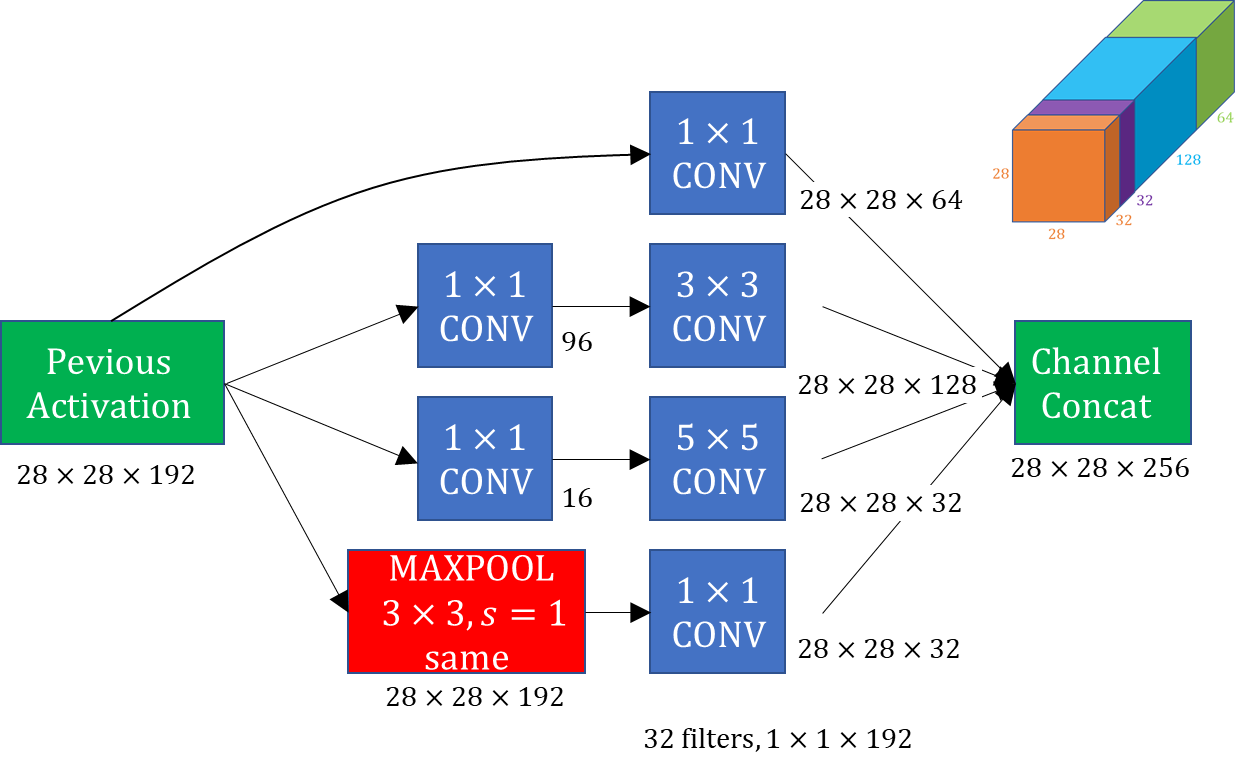

The architecture consists of three parts stacked on top of one another:

*    Stem (data ingestion): The first few convolutional layers perform data preprocessing to downscale images to a smaller size.
*    Body (data processing): The next many Inception modules perform the bulk of data processing.
*    Head (prediction): The final fully-connected layer and softmax produces a probability distribution for image classification.

In [6]:
def inception_module(x, filters):
    f1, f2_reduce, f2, f3_reduce, f3, f4 = filters

    branch1 = Conv2D(f1, kernel_size=1, padding='same', activation='relu')(x)

    branch2 = Conv2D(f2_reduce, kernel_size=1, padding='same', activation='relu')(x)
    branch2 = Conv2D(f2, kernel_size=3, padding='same', activation='relu')(branch2)

    branch3 = Conv2D(f3_reduce, kernel_size=1, padding='same', activation='relu')(x)
    branch3 = Conv2D(f3, kernel_size=5, padding='same', activation='relu')(branch3)

    branch4 = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    branch4 = Conv2D(f4, kernel_size=1, padding='same', activation='relu')(branch4)

    output = Concatenate()([branch1, branch2, branch3, branch4])
    return output

In [7]:
def create_inception_net(input_shape, num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [8]:
# defining the input shape for CIFAR-10 (32x32 RGB images)
input_shape = (32, 32, 3)

In [9]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# normalizing the data to [0, 1] range
x_train = x_train / 255.0
x_test = x_test / 255.0

# one-hot encoding the labels for classification tasks
y_train_class = tf.keras.utils.to_categorical(y_train, 10)
y_test_class = tf.keras.utils.to_categorical(y_test, 10)

In [10]:
with tf.device('/GPU:0'):
    model_inception = create_inception_net(input_shape, num_classes=10)
    model_inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history_inception = model_inception.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 155s 119ms/step - accuracy: 0.2728 - loss: 1.9088 - val_accuracy: 0.5265 - val_loss: 1.2747
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 64ms/step - accuracy: 0.6031 - loss: 1.0883 - val_accuracy: 0.6421 - val_loss: 1.0020
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.7151 - loss: 0.7992 - val_accuracy: 0.7418 - val_loss: 0.7365
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.7803 - loss: 0.6175 - val_accuracy: 0.7661 - val_loss: 0.6715
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8240 - loss: 0.5012 - val_accuracy: 0.7533 - val_loss: 0.7195
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8481 - loss: 0.4311 - val_accuracy: 0.7721 - val_loss: 0.7045
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 63ms/step - accuracy: 0.8751 - loss: 0.3636 - val_accuracy: 0.8105 - val_loss: 0.6229
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 60ms/step - accuracy: 0.8959 - loss: 0.2983 

In [11]:
test_loss_inception, test_acc_inception = model_inception.evaluate(x_test, y_test_class)
print(f"Test Accuracy for Classification Task: {test_acc_inception * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.8249 - loss: 0.6015
Test Accuracy for Classification Task: 82.17%


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


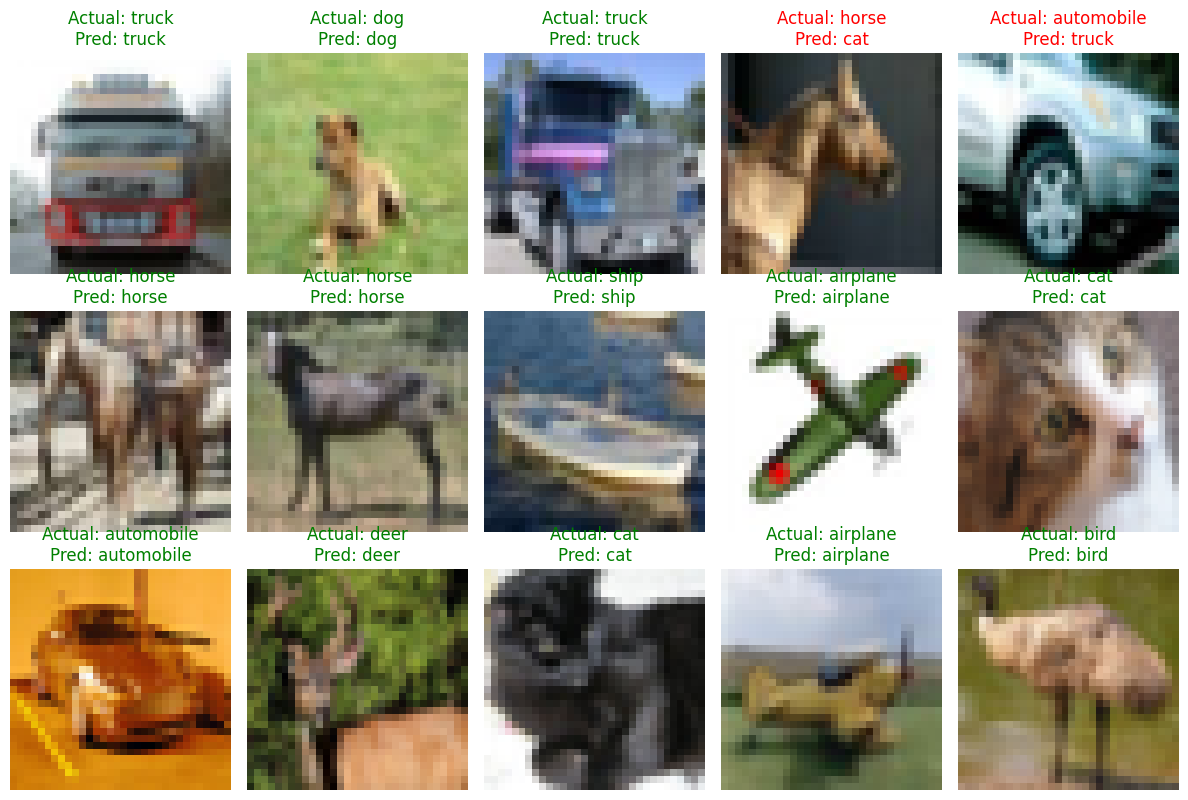

In [14]:
plot_sample_classification_predictions(model_inception, x_test, y_test_class)

In [15]:
# *********************************************
# TASK 2 - ADDING SQUEEZE AND EXCITATION BLOCKS
# *********************************************

# Modify the Inception model to include Squeeze-and-Excitation (SE) blocks,
# which enhance feature learning by re-weighting channels based on importance.

# Implement an SE block:
# 1. Perform Global Average Pooling on feature maps.
# 2. Pass them through two dense layers (bottleneck).
# 3. Use a sigmoid activation to generate attention weights.
# 4. Multiply these weights with feature maps.

# Insert SE blocks after each Inception module. Compare the performance of the
# modified SE-Inception model with the original.

# WRITE YOUR CODE HERE
# Define Squeeze-and-Excitation (SE) Block
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, MaxPooling2D, Reshape, Multiply
from tensorflow.keras.models import Model

def se_block(input_tensor, reduction=16):
    channels = input_tensor.shape[-1]
    x = GlobalAveragePooling2D()(input_tensor)
    x = Dense(channels // reduction, activation='relu')(x)
    x = Dense(channels, activation='sigmoid')(x)
    x = Reshape((1, 1, channels))(x)
    return Multiply()([input_tensor, x])

def modified_inception_net(input_shape, num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)

    x = inception_module(x, [64, 96, 128, 16, 32, 32])
    x=se_block(x)
    x = inception_module(x, [128, 128, 192, 32, 96, 64])
    x=se_block(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, [192, 96, 208, 16, 48, 64])
    x=se_block(x)
    x = inception_module(x, [160, 112, 224, 24, 64, 64])
    x=se_block(x)
    x = inception_module(x, [128, 128, 256, 24, 64, 64])
    x=se_block(x)
    x = inception_module(x, [112, 144, 288, 32, 64, 64])
    x=se_block(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x=se_block(x)
    x = inception_module(x, [256, 160, 320, 32, 128, 128])
    x=se_block(x)

    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model


In [19]:
with tf.device('/GPU:0'):
    model_inception = modified_inception_net(input_shape, num_classes=10)
    model_inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    history_inception = model_inception.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 127s 105ms/step - accuracy: 0.2199 - loss: 1.9872 - val_accuracy: 0.4647 - val_loss: 1.4606
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.5222 - loss: 1.2934 - val_accuracy: 0.5633 - val_loss: 1.1987
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 51s 65ms/step - accuracy: 0.6571 - loss: 0.9525 - val_accuracy: 0.6166 - val_loss: 1.0600
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 68ms/step - accuracy: 0.7235 - loss: 0.7805 - val_accuracy: 0.6241 - val_loss: 1.0611
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 79s 65ms/step - accuracy: 0.7770 - loss: 0.6387 - val_accuracy: 0.7633 - val_loss: 0.6925
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.8136 - loss: 0.5301 - val_accuracy: 0.7682 - val_loss: 0.6776
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - accuracy: 0.8436 - loss: 0.4446 - val_accuracy: 0.8005 - val_loss: 0.5898
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.8657 - loss: 0.3803 

In [20]:
test_loss_inception, test_acc_inception = model_inception.evaluate(x_test, y_test_class)
print(f"Test Accuracy for Classification Task: {test_acc_inception * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8205 - loss: 0.5962
Test Accuracy for Classification Task: 82.09%


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


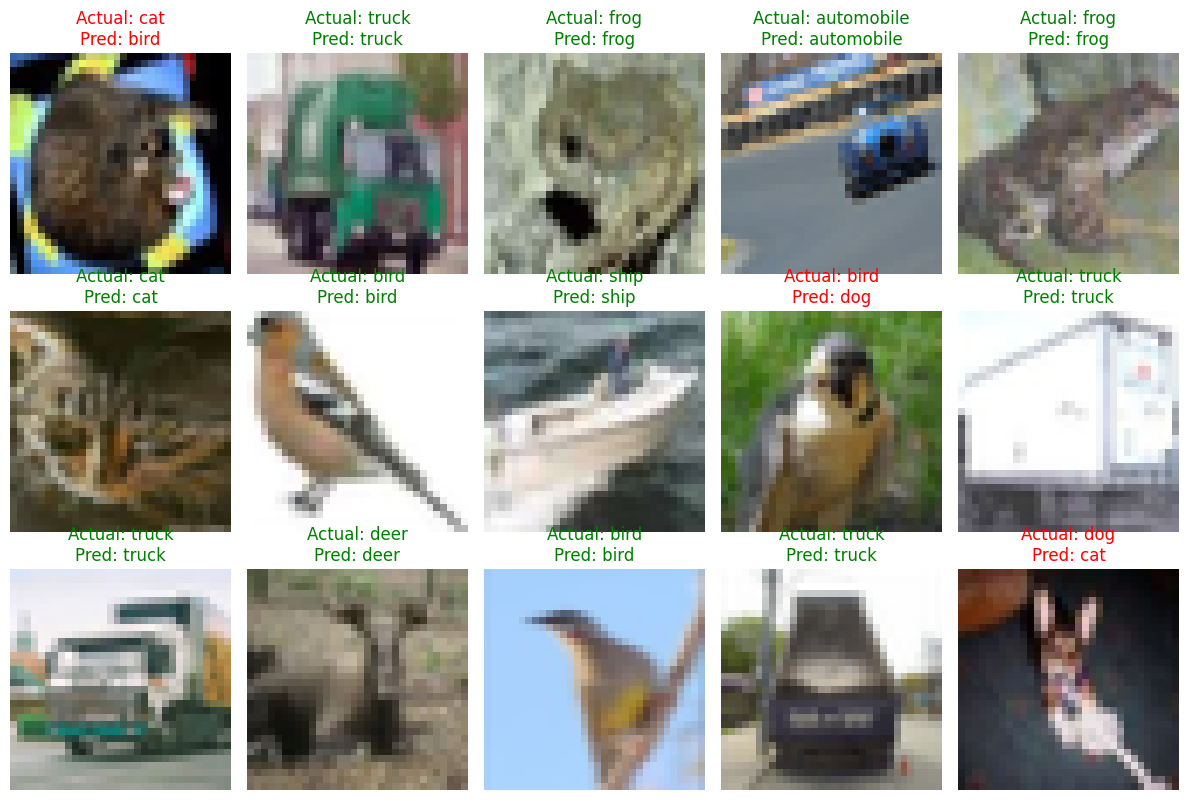

In [21]:
plot_sample_classification_predictions(model_inception, x_test, y_test_class)

## **Xception**

In [22]:
from tensorflow.keras.layers import SeparableConv2D

Xception, short for Extreme Inception, is a Deep Learning model developed by Francois Chollet at Google, continuing the popularity of Inception architecture, and further perfecting it.

The inception architecture utilizes inception modules, however, the Xception model replaces it with depthwise separable convolution layers, which totals 36 layers. When we compare the Xception model with the Inception V3 model, it only slightly performs better on the ImageNet dataset, however, on larger datasets consisting of 350 million images, Xception performs significantly better.

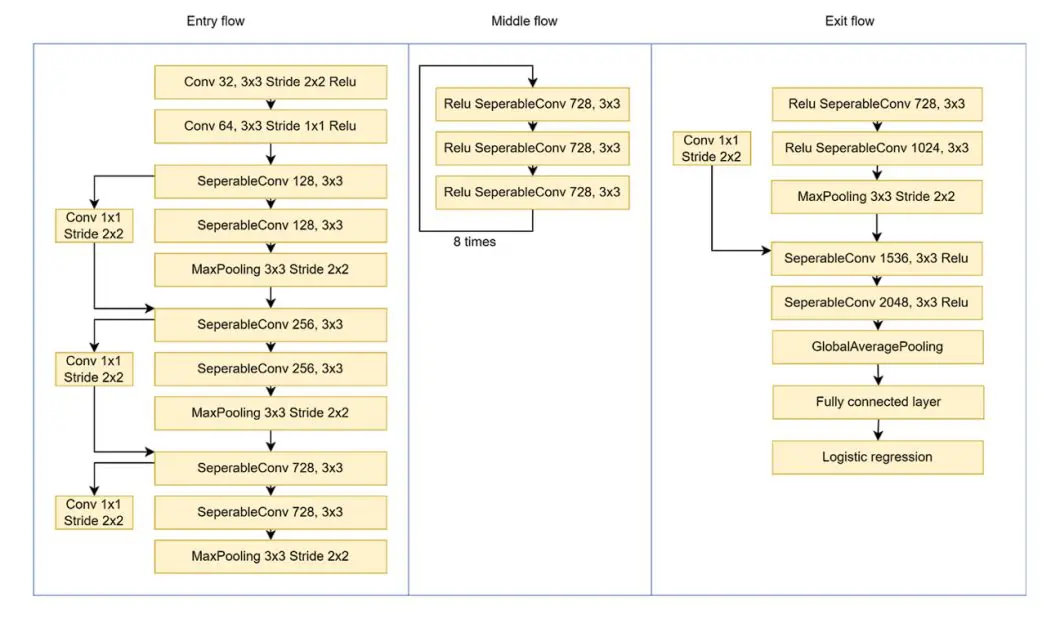

Standard convolution learns filters in 3D space, with each kernel learning width, height, and channels.

Whereas, a depthwise separable convolution divides the process into two distinctive processes using depth-wise convolution and pointwise convolution:

*    Depthwise Convolution: Here, a single filter is applied to each input channel separately. For example, if an image has three color channels (red, green, and blue), a separate filter is applied to each color channel.
*    Pointwise Convolution: After the depthwise convolution, a pointwise convolution is applied. This is a 1×1 filter that combines the output of the depthwise convolution into a single feature map.

In [23]:
def create_xception_net(input_shape, num_classes=10):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    for filters in [128, 256, 728]:
        residual = Conv2D(filters, kernel_size=1, strides=2, padding='same')(x)
        residual = BatchNormalization()(residual)

        x = SeparableConv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = SeparableConv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
        x = tf.keras.layers.Add()([x, residual])

    x = SeparableConv2D(1024, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

In [24]:
# defining the input shape for CIFAR-10 (32x32 RGB images)
input_shape = (32, 32, 3)

In [25]:
with tf.device('/GPU:0'):
    model_xception = create_xception_net(input_shape, num_classes=10)
    model_xception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    # Freeze first 50% of layers for fine-tuning
    for layer in model_xception.layers[:len(model_xception.layers)//2]:
        layer.trainable = False
    history_xception = model_xception.fit(x_train, y_train_class, epochs=10, batch_size=64, validation_data=(x_test, y_test_class))

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.3837 - loss: 1.7084 - val_accuracy: 0.4870 - val_loss: 1.4006
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.5338 - loss: 1.3118 - val_accuracy: 0.5080 - val_loss: 1.4205
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5968 - loss: 1.1288 - val_accuracy: 0.5310 - val_loss: 1.3389
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6595 - loss: 0.9609 - val_accuracy: 0.5337 - val_loss: 1.3782
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7266 - loss: 0.7778 - val_accuracy: 0.5460 - val_loss: 1.4282
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7949 - loss: 0.5843 - val_accuracy: 0.5481 - val_loss: 1.5356
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8490 - loss: 0.4343 - val_accuracy: 0.5313 - val_loss: 1.6592
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8917 - loss: 0.3121 - val_accuracy:

In [26]:
test_loss_xception, test_acc_xception = model_xception.evaluate(x_test, y_test_class)
print(f"Test Accuracy for Classification Task: {test_acc_xception * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5212 - loss: 2.2582
Test Accuracy for Classification Task: 52.39%


In [27]:
# Save fine-tuned model
model_xception.save("xception_cifar10.h5")
print("Fine-tuned model saved!")

Fine-tuned model saved!


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


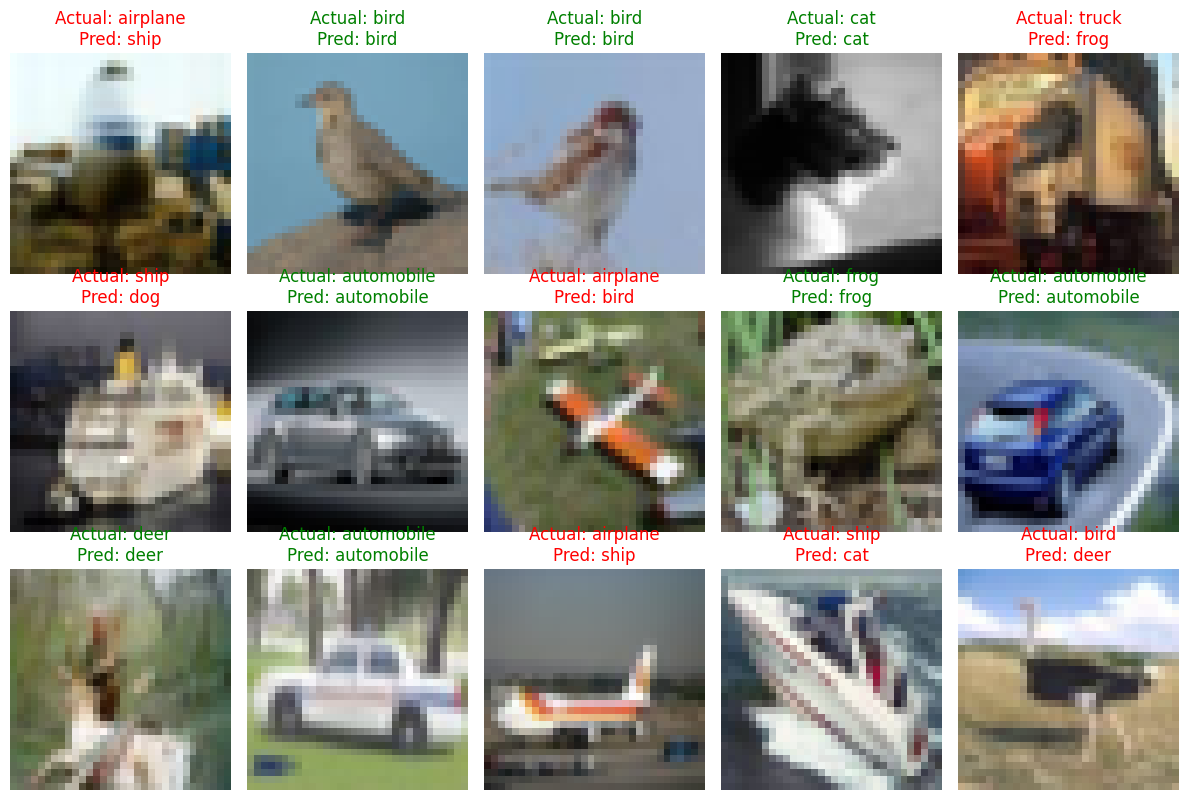

In [28]:
plot_sample_classification_predictions(model_xception, x_test, y_test_class)

In [35]:
# *************************************************
# TASK 3 - TRAINING XCEPTION ON A DIFFERENT DATASET
# *************************************************

# Train Xception on some other small dataset and fine-tune it for better
# generalization. You can freeze the first 50% of Xception's layers to use
# pre-trained weights.

# WRITE YOUR CODE HERE
# Use the same Xception training process as above
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, SeparableConv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

# Define the custom layer
class Cast(tf.keras.layers.Layer):
    def __init__(self, dtype='float32', **kwargs):
        super(Cast, self).__init__(**kwargs)
        # Add a setter for dtype
        self._dtype = dtype

    def call(self, inputs):
        return tf.cast(inputs, self._dtype)

    def get_config(self):
        config = super(Cast, self).get_config()
        config.update({'dtype': self._dtype})
        return config

    @property
    def dtype(self):
        return self._dtype

    @dtype.setter
    def dtype(self, value):
        self._dtype = value

# Load the pre-trained Xception model with a custom layer scope
with tf.keras.utils.custom_object_scope({'Cast': Cast}):
    model_xception_new = load_model("xception_cifar10.h5")

# Load Fashion-MNIST dataset
(x_train_new, y_train_new), (x_test_new, y_test_new) = fashion_mnist.load_data()

# Convert grayscale to 3-channel (since Xception expects RGB)
x_train_new = np.stack([x_train_new] * 3, axis=-1)
x_test_new = np.stack([x_test_new] * 3, axis=-1)

# Resize to 32x32 (original Fashion-MNIST is 28x28)
x_train_new = tf.image.resize(x_train_new, [32, 32]).numpy()
x_test_new = tf.image.resize(x_test_new, [32, 32]).numpy()

# Normalize images
x_train_new, x_test_new = x_train_new / 255.0, x_test_new / 255.0

# Convert labels to categorical
num_classes = 10
y_train_new = tf.keras.utils.to_categorical(y_train_new, num_classes)
y_test_new = tf.keras.utils.to_categorical(y_test_new, num_classes)

# Freeze first 50% of layers for fine-tuning
for layer in model_xception_new.layers[:len(model_xception_new.layers)//2]:
    layer.trainable = False

# Compile the model again
model_xception_new.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train on Fashion-MNIST dataset
history_xception_new = model_xception_new.fit(x_train_new, y_train_new, epochs=10, batch_size=64,
                                              validation_data=(x_test_new, y_test_new))

# Evaluate the model
test_loss_xception_new, test_acc_xception_new = model_xception_new.evaluate(x_test_new, y_test_new)
print(f"Test Accuracy for Fashion-MNIST: {test_acc_xception_new * 100:.2f}%")

# Save fine-tuned model
model_xception_new.save("xception_fashion_mnist.h5")
print("Fine-tuned model on Fashion-MNIST saved!")

# *************************************************
# *************************************************

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 29s 16ms/step - accuracy: 0.7461 - loss: 1.2529 - val_accuracy: 0.8668 - val_loss: 0.3616
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - accuracy: 0.8903 - loss: 0.2935 - val_accuracy: 0.8694 - val_loss: 0.3700
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9135 - loss: 0.2334 - val_accuracy: 0.8734 - val_loss: 0.3547
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9293 - loss: 0.1921 - val_accuracy: 0.8695 - val_loss: 0.3699
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9404 - loss: 0.1609 - val_accuracy: 0.8716 - val_loss: 0.3879
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9508 - loss: 0.1318 - val_accuracy: 0.8704 - val_loss: 0.4212
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9590 - loss: 0.1128 - val_accuracy: 0.8637 - val_loss: 0.4533
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.9632 - loss: 0.1021 - val_accurac

Test Accuracy for Fashion-MNIST: 87.57%
Fine-tuned model on Fashion-MNIST saved!


### **Task 1 - Working with Grayscale Images (ResNet Modification)**  

In this task, I modified the ResNet model to work with grayscale images (single-channel input instead of the usual three-channel RGB format). The objective is to adapt ResNet for datasets like MNIST or Fashion-MNIST, which contain grayscale images, and then retrain the model to achieve optimal classification performance.

#### **Key Modifications and Implementation Steps:**  
1. **ResNet Model Adaptation:**  
   - The input layer is adjusted to accept grayscale images with a shape of **(28, 28, 1)** instead of the typical **(224, 224, 3)** used in standard ResNet implementations.  
   - Convolutional layers and residual blocks are structured to efficiently process grayscale inputs.  
   
2. **Dataset Preprocessing:**  
   - The **Fashion-MNIST dataset** is loaded, which consists of 28x28 grayscale images belonging to 10 different clothing categories.  
   - Image pixel values are **normalized** to a range of [0,1] for better training stability.  
   - Labels are **one-hot encoded** to convert them into a format suitable for multi-class classification.

3. **Training on a GPU for Efficiency:**  
   - The model is trained using the Adam optimizer and categorical cross-entropy loss.  
   - A batch size of 64 is used, and the model is trained for 10 epochs.  
   - The training process runs on a GPU to accelerate computations.  

This task demonstrates how deep learning models designed for RGB images can be adapted for grayscale images, ensuring flexibility across different datasets.

### **Task 2 - Adding Squeeze-and-Excitation (SE) Blocks to Inception Model**  

In this task, I enhanced the **Inception model** by integrating **Squeeze-and-Excitation (SE) blocks**, which improve feature learning by re-weighting channels based on their importance. The SE mechanism helps the model focus on the most relevant features by adaptively recalibrating channel-wise feature responses.  

---

### **Key Enhancements and Implementation Steps:**

1. **Squeeze-and-Excitation (SE) Block Implementation:**  
   - **Squeeze Step:** Global Average Pooling (GAP) is applied to each channel, reducing the spatial dimensions and capturing global information.  
   - **Excitation Step:**  
     - The pooled features are passed through two **dense layers** to form a bottleneck.  
     - A **sigmoid activation** is applied to compute attention weights, which determine the importance of each channel.  
   - **Reweighting:** The attention weights are multiplied with the original feature maps to enhance important channels.

2. **Integration with Inception Model:**  
   - I inserted an **SE block after each Inception module** to improve feature representation.  
   - The modified architecture preserves the efficiency of the Inception model while enhancing its ability to focus on meaningful patterns.  

3. **Final Architecture Overview:**  
   - Initial **convolutional layer** for feature extraction.  
   - Multiple **Inception modules** with interleaved **SE blocks**.  
   - **Global Average Pooling** followed by a **fully connected (Dense) layer** for classification.  

4. **Performance Comparison:**  
   - The modified **SE-Inception model** is compared with the **original Inception model** in terms of accuracy and efficiency.  
   - SE blocks are expected to enhance classification performance by improving feature learning without significantly increasing computational cost.  

---

### **Objective:**  
This task demonstrates the **power of attention mechanisms** in deep learning models. By incorporating **SE blocks**, I made the Inception model more **adaptive** and **effective** for feature selection, leading to potential improvements in **classification accuracy** on datasets like **CIFAR-10**.

### **Task 3 - Training Xception on a Different Dataset**  

In this task, we fine-tuned the **Xception** model on a new dataset, **Fashion-MNIST**, which consists of grayscale images of clothing items. The goal is to leverage **transfer learning** by using pre-trained weights from Xception (originally trained on CIFAR-10) and adapting the model for better generalization on a different dataset.  

---

### **Key Steps and Implementation Details:**  

1. **Loading the Pre-Trained Xception Model:**  
   - The **Xception model**, previously trained on CIFAR-10, is loaded using `load_model("xception_cifar10.h5")`.  
   - A custom `Cast` layer is defined to ensure compatibility with TensorFlow’s type handling.  

2. **Preparing the Fashion-MNIST Dataset:**  
   - The dataset is originally **grayscale (1 channel, 28x28 resolution)**. Since Xception expects **RGB images (3 channels, larger size)**, we:  
     - **Duplicate the grayscale channel** across three dimensions to form an RGB image.  
     - **Resize** the images to **32x32** to match Xception’s input size.  
     - **Normalize pixel values** to the range `[0, 1]`.  
   - Labels are **one-hot encoded** for multi-class classification.  

3. **Fine-Tuning Xception for Fashion-MNIST:**  
   - **Freezing the first 50% of layers** in Xception ensures that lower-level features (edges, textures) remain unchanged, preserving pre-trained knowledge.  
   - The remaining layers are **trainable**, allowing the model to adapt to Fashion-MNIST’s unique patterns.  

4. **Training and Evaluation:**  
   - The model is compiled using the **Adam optimizer** and `categorical_crossentropy` loss.  
   - It is trained for **10 epochs** on Fashion-MNIST with a batch size of **64**.  
   - The fine-tuned model is evaluated on the test set, and accuracy is printed.  

5. **Saving the Fine-Tuned Model:**  
   - The newly trained model is saved as **"xception_fashion_mnist.h5"** for future use.  

---

### **Objective of This Task:**  
This task demonstrates the **power of transfer learning** in deep learning. By adapting a **pre-trained model** to a new dataset with **minimal training**, we can achieve **better generalization** and **faster convergence**, making deep learning models more efficient in real-world applications.